In [1]:
from utils import *
from tqdm import tqdm
import torch.optim as optim
from advTraining import *
import copy

In [2]:
args = {
    'partition':"dirichlet",
    'beta':0.4,
    'num_users':10,
    'dataset':'cifar10',
    'comment':'ModelSave',
    'model':'cnn',
    'save':'ce',
    'epochs':20,
    'local_bs':256,
    'lr':0.01,
    'local_ep':10,
}
sets = {"mnist": dict(step_size=0.01, epsilon=0.3),
        "fmnist": dict(step_size=0.01, epsilon=0.3),
        "cifar10": dict(step_size=2.0 / 255, epsilon=8.0 / 255),
        "svhn": dict(step_size=2.0 / 255, epsilon=8.0 / 255),
        "cifar100": dict(step_size=2.0 / 255, epsilon=8.0 / 255),
        }

cfgs = sets[args['dataset']]
args['cfgs'] = cfgs

In [3]:
setup_seed(2021)
train_dataset, test_dataset, net_dataidx_map, train_data_cls_counts = process_data(args['num_users'], args['dataset'], args['partition'])  # 获得切分好的数据集
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256, shuffle = False, num_workers = 4)  # 制作DataLoader
model = get_model(args['dataset'])  # 获取模型
description = "inference acc={:.4f}% loss={:.2f}, best_acc = {:.2f}%"  # 生成表述语言
cls_num_list = get_cls_num_list(train_data_cls_counts,args)  # 将字典转化为列表
epochs = args['epochs']  # 设定epochs的总数
total = len(test_dataset)  # 计算测试集的长度
bst_cln_acc = -1
bst_rob_acc = -1
accurate = list()
robust = list()

/home/yunhao/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yunhao/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
for epoch in tqdm(range(epochs)):
    local_weights = []  # 客户端参数
    for idx in range(args['num_users']):
        client_weight = client_train(idx,args,model,cls_num_list,train_dataset,net_dataidx_map)
        local_weights.append(copy.deepcopy(client_weight))
    global_weight = average_weights(local_weights)
    global_model = model
    global_model.load_state_dict(global_weight)
    print('================================================================')
    natural_err_total, robust_err_total = eval_adv_test_whitebox(global_model, test_loader, cfgs, args['dataset'])
    cln_acc, rob_acc = (total - natural_err_total) * 1.0 / total, (total - robust_err_total) * 1.0 / total
    print("Epoch:{},\t cln_acc:{}, \t rob_acc:{}".format(epoch, cln_acc, rob_acc))
    print("Epoch:{},\t bst_cln_acc:{}, \t bst_rob_acc:{}".format(epoch, bst_cln_acc , bst_rob_acc))
    save_checkpoint({
            'state_dict': global_model.state_dict(),
            'epoch': epoch,
        }, cln_acc > bst_cln_acc, "ModelSave/BestAcc.pth")

    save_checkpoint({
        'state_dict': global_model.state_dict(),
        'epoch': epoch,
    }, rob_acc > bst_rob_acc, "ModelSave/BestRob.pth")
    bst_cln_acc = max(bst_cln_acc, cln_acc)
    bst_rob_acc = max(bst_rob_acc, rob_acc)
    accurate.append(bst_cln_acc)
    robust.append(bst_rob_acc)

  0%|          | 0/20 [00:00<?, ?it/s]/home/yunhao/anaconda3/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch:0,	 cln_acc:0.25220000743865967, 	 rob_acc:0.16279999911785126
Epoch:0,	 bst_cln_acc:-1, 	 bst_rob_acc:-1


  5%|▌         | 1/20 [1:21:12<25:43:03, 4872.82s/it]

In [ ]:
save_checkpoint({
            'state_dict': global_model.state_dict(),
            'epoch': epoch,
        }, 1 > 0, "ModelSave/Epoch-{}-last.pth".format(epoch))

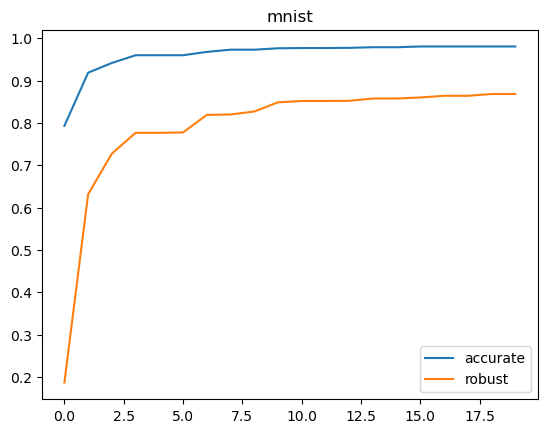

In [ ]:
import matplotlib.pyplot as plt
accurate_plot = torch.tensor(accurate).cpu()
robust_plot = torch.tensor(robust).cpu()
plt.plot(accurate_plot,label = 'accurate')
robust_plot = torch.tensor(robust).cpu()
plt.plot(robust_plot,label = 'robust')
plt.title(args['dataset'])
plt.legend()